In [36]:
import os
import re
import glob

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB

from classifier.detector_classifier import DetectorClassifier
from concept_drift.adwin import AdWin
from concept_drift.page_hinkley import PageHinkley
from evaluation.prequential import prequential

In [25]:
def get_values(dir_ctrl):
    print("Reading",dir_ctrl)
    files = glob.glob(os.path.join(dir_ctrl, '*.log'))
    sarss = []
    sars = None
    file_id = 0
    for filename in sorted(files):
        with open(filename, 'r') as f:
            lines = f.readlines()
        for i in range(len(lines)):
            _l = lines[i]
            if 'iteration' in _l:
                sars = None
            if 'Frequency: ' in _l:
                f = re.findall(r"[-+]?\d*\.\d+|\d+", _l)
                if len(f) == 10:
                    # ok
                    sars = dict(zip(['Frequency', 'Medium busy', 'Busy time', 'Active time'], f[6:]))
            elif sars is not None:
                # ok, got at least Frequency...
                if '] AP0 txpower:' in _l:
                    f = re.findall(r"[-+]?\d*\.\d+|\d+", _l)
                    if len(f) == 11:
                        sars.update(dict(zip(['txpower', 'new_txpower', 'channel', 'new_channel'], f[7:])))
                    if 'new Medium busy' in sars:
                        sars.update({'file_id': file_id})
                        file_id += 1
                        sarss.append(sars)
                    sars = None
                elif '] rewards:' in _l:
                    sars['r'] = _l.split('] rewards:')[1].replace('\n', '').strip()
                    if 'None' in sars['r'] :
                        sars = None  # error, skip
                    else:
                        try:
                            ## find new state
                            for j in range(1, 10):
                                _ll = lines[i + j]
                                if 'Frequency: ' in _ll:                                  
                                    f = re.findall(r"[-+]?\d*\.\d+|\d+", _ll)
                                    if len(f) == 10:
                                        # ok
                                        new_sars = dict(zip(['new Medium busy', 'new Busy time', 'new Active time'], f[7:]))
                                        sars.update(new_sars)
                                    break
                        except (KeyError, IndexError):
                            sars = None  # error skip
    return sarss

## create a temporary dir

In [3]:
TEMP = 'temp'
if not os.path.exists(TEMP):
    os.mkdir(TEMP)

# extract MAB results to TEMP

In [4]:
files = glob.glob('../MAB1/data/*.tar.xz')

In [9]:
for f in files:
    print("Extracting {}".format(os.path.basename(f)))
    s = "tar -C {} -xJf {}".format(TEMP, f)
    # print(s)
    os.system(s)

Extracting sta2.tar.xz
Extracting removed.tar.xz
Extracting ap.tar.xz
Extracting ctrl.tar.xz
Extracting sta1.tar.xz


In [26]:
sarss = get_values(os.path.join(TEMP, 'ctrl'))

Reading temp/ctrl


In [27]:
print("Found", len(sarss))

Found 237646


In [35]:
os.system("rm -fr {}".format(TEMP))

0

In [31]:
data = pd.DataFrame(sarss)

In [94]:
y = data['r'].astype('float')
y = np.sign(np.concatenate(([1], y[1:].values - y[:-1].values)))
y[y==-1] = 0  # y will have only 0s and 1s

In [83]:
X = data[['Active time', 'Medium busy', 'channel',
       'new Active time', 'new Busy time', 'new Medium busy',
       'new_channel', 'new_txpower', 'txpower']].values

# Concept Drift ADWIN

In [95]:
n_train = 1000 # X.shape[0]

In [96]:
# window size
w = 100


GaussianNB:
Mean acc within the window 100: 0.8668605004944094

Page-Hinkley:
Drift detection: 72
Mean acc within the window 100: 0.7386264716073797

AdWin:
Drift detection: 677
Mean acc within the window 100: 0.8022151230107419


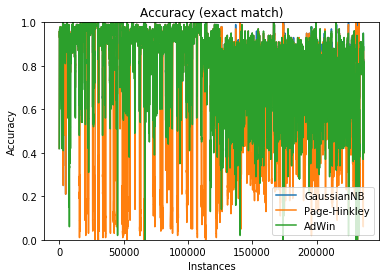

In [97]:
clfs = [
    GaussianNB(),
    DetectorClassifier(GaussianNB(), PageHinkley(), np.unique(y)),
    DetectorClassifier(GaussianNB(), AdWin(), np.unique(y))
]
clfs_label = ["GaussianNB", "Page-Hinkley", "AdWin"]

plt.title("Accuracy (exact match)")
plt.xlabel("Instances")
plt.ylabel("Accuracy")

for i in range(len(clfs)):
    print("\n{}:".format(clfs_label[i]))
    with np.errstate(divide='ignore', invalid='ignore'):
        y_pre, time = prequential(X, y, clfs[i], n_train)
    if clfs[i].__class__.__name__ == "DetectorClassifier":
        print("Drift detection: {}".format(clfs[i].change_detected))
    estimator = (y[n_train:] == y_pre) * 1

    acc_run = np.convolve(estimator, np.ones((w,)) / w, 'same')
    print("Mean acc within the window {}: {}".format(w, np.mean(acc_run)))
    plt.plot(acc_run, "-", label=clfs_label[i])

plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.show()